In [81]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### STEP 1. Load Data

In [82]:
path_to_file = '/content/drive/MyDrive/data/chatbot/ChatbotData.csv'

df = pd.read_csv(path_to_file)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


### STEP 2. Preprocessing Data

- 정규 표현식을 사용하여 tokenizing 에 방해가 될 수 있는 요인을 삭제
   - 구두점을 띄어쓰기로 대체
   - 한국어 데이터인 점을 감안 영어와 한국어, 대화에 사용되는 물음표 느낌표 등을 제외한 특수문자 삭제

In [83]:
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  sentence = re.sub(r"([?.!,])",r"\1",sentence)
  sentence = re.sub(r'[" "]'," ",sentence)

  sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+"," ",sentence)
  sentence = sentence.strip()
  return sentence

- 데이터를 로드함과 동시에 질문과 답변 쌍으로 전처리

In [84]:
def load_conversations():
  with open(path_to_file,errors='ignore') as file:
    lines = file.readlines()

  inputs,outputs = [],[]
  with open(path_to_file) as file:
    lines = csv.reader(file)
    next(lines)
    for line in lines:
      inputs.append(preprocess_sentence(line[0]))
      outputs.append(preprocess_sentence(line[1]))

  return inputs,outputs

In [85]:
questions,answers = load_conversations()
print('전체 질문 샘플 수: ',len(questions))
print('전채 답변 샘플 수: ',len(answers))
print('전처리 후의 22 번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22 번째 답변 샘플: {}'.format(answers[21]))

전체 질문 샘플 수:  11823
전채 답변 샘플 수:  11823
전처리 후의 22 번째 질문 샘플: 가스비 장난 아님
전처리 후의 22 번째 답변 샘플: 다음 달에는 더 절약해봐요.


### STEP 3. Tokenizing using SubwordTextEncoder 

- vocabulary 만들기 
   - TensorFlow Datasets SubwordTextEncoder를 토크나이저로 사용한다.  단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩한다
   - 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.

In [86]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers,target_vocab_size=2**13)

In [87]:
START_TOKEN , END_TOKEN = [tokenizer.vocab_size] , [tokenizer.vocab_size + 1]
print('START TOKEN의 번호: ',START_TOKEN)
print('END TOKEN의 번호: ',END_TOKEN)

START TOKEN의 번호:  [8131]
END TOKEN의 번호:  [8132]


In [88]:
VOCAB_SIZE = tokenizer.vocab_size + 2 
print(VOCAB_SIZE)

8133


-  각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
  - 데이터의 길이를 확인해 적절한 길이로 최대 문장 길이를 적절히 정하고 해당 길이로 패딩

In [89]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5737, 607, 2481, 4144]
정수 인코딩 후의 21번째 답변 샘플: [2351, 7482, 5, 6247, 94, 7921]


In [90]:
questions_len = [len(s.split()) for s in questions]
answers_len = [len(s.split()) for s in answers]
print(f'questions 최대 길이 : {np.max(questions_len)}')
print(f'questions 평균 길이 : {np.mean(questions_len)}')
print(f'answers 최대 길이 : {np.max(answers_len)}')
print(f'answers 평균 길이 : {np.mean(answers_len)}')

questions 최대 길이 : 15
questions 평균 길이 : 3.5874989427387294
answers 최대 길이 : 21
answers 평균 길이 : 3.694070878795568


In [91]:
MAX_LENGTH = 12

def tokenize_and_filter(inputs,outputs):
  tokenized_inputs,tokenized_outputs = [],[]

  for (sentence1,sentence2) in zip(inputs,outputs):
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH :
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs,maxlen=MAX_LENGTH,padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs,maxlen=MAX_LENGTH,padding='post')

  return tokenized_inputs, tokenized_outputs

In [92]:
questions,answers = tokenize_and_filter(questions,answers)
print('단어장 크기 : ',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장 크기 :  8133
필터링 후의 질문 샘플 개수: 10752
필터링 후의 답변 샘플 개수: 10752


- 교사강요 사용하기 

In [93]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

#### STEP 4. Build Model

- transformer 
  - 텍스트 문장을 input 으로 받기 위해 단어를 embedding vector 로 변환하는 과정은 다른 모델들과 동일
  - 그러나 embedding vector 에 어떤 값을 더해준 뒤에 입력으로 사용한다
  - 문장에 있는 단어들을 한개씩 순차적으로 받지 않고, 모든 단어를 한꺼번에 입력 받기 때문에, 모델에게 어순 정보를 주어야 함
  - 아래의 함수들을 이용해 transformer model 을 정의
- positional encoding layer 
  - transformer 모델에서 embedding vector 에 더해주는 값
  - sin 과 cos 를 이용해 단어의 순서정보를 더해줌
  - 같은 단어라 하더라도 positional encoding 을 통해 다른 vector 값을 가지게 됨
- scaled dot product
  - attention 의 유사도를 구하는 방법
  - ATTENTION
    - 주어진 query 에 대해서 모든 key 와의 유사도 를 구하는 함수
    - 이 유사도를 key 와 mapping 되어있는 value에 반영
    - 반영된 value 값들을 뭉쳐 더해주면 최종 결과인 attention value
  
- multi-head attention
  - `num_heads` 라는 변수를 이용해 몇개의 머리를 사용하여 연산을 수행할지 결정
  - embedding vector 의 차원인 `d_model` 을 `num_heads` 의 개수만큼 나누어 수행 후 다시 합쳐 d_model 차원으로 돌려놓는다
  - 각각의 머리가 각각 다른 관점에서 attention을 수행하므로, 한번의 어텐션으로는 놓칠 수 있는 정보를 캐치할 수 있음
- padding mask
    - padding token을 이용한 방법 
    > *padding* :<br>
        문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해준 길이보다 짧은 경우에 숫자 0 을 차워 문장 길이를 맞춰주는 자연어 전처리 방법
    - 이렇게 주어진 숫자 0 은 실제로 가진 의미가 없기 때문에 실제 연산시 제외되는 것이 좋다
    - 숫자가 0 인 위치를 체크해서 padding masking 을 실행
- look-ahead mask
  - 다음 단어 가리기 
  - RNN 
      - 각 단어가 순서대로 들어가고, 자신보다 앞에 있는 단어들만 참고해서 다음단어 예측
      - first step : what -> is
      - second step : what is -> the
      - third step : what is the -> problem
  - Transformer 
      - 전체 문장이 문장행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어 예측
      - 우리가 원하는 것 : 이전 단어들로부터 다음 단어를 예측하는 것 
      - 뒤에 나올 단어를 가리는 masking 진행
- encoder
  - 2개의 sublayer
    1. self attention(using multi head attention)
    2. feed forward neural network 
  
  - encoder layer 를 embedding layer 와 positional encoding 을 연결하고, 원하는 만큼 encoder layer 를 더 쌓아 transformer encoder 완성 
  - encoder 와 decoder 내부에 각 sublayer 이후 훈련을 돕는 nomalization 사용
  - hyper-parameter 인 `num_layers`개수 만큼 layer 쌓음
- decoder
  - 3 개의 sublayer
    1. self attention(using multi-head attention)
    2. incoder-decoder attention(using multi-head_attention)
        - 이 부분에서 인코더가 디코더에 입력문장으로 부터 정보를 전달하는 과정 이루어짐
    3. feed forward neural network


In [94]:
# positional encoding layer
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


In [95]:
# scaled dot product attention function
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output


In [96]:
# multi head attention
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [97]:
# padding mask
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [98]:
# look-ahead masking
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)


In [99]:
# Encoder layer function
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [100]:
# stacking encoder layers to build encoder
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [101]:
# Decoder function
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [102]:
# stacking decoder layers to build decoder
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [103]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [104]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3136256     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- loss function

In [105]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

- learning rate
  - 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있다
  -  이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 한다

In [106]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

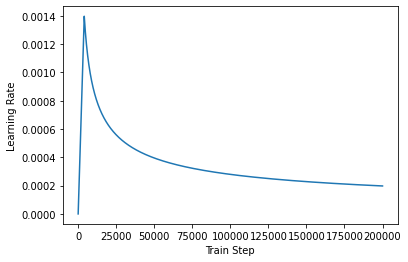

In [107]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### STEP 5. Train Model & Testing chatbot

In [108]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [109]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
168/168 [==============================] - 12s 31ms/step - loss: 4.8307 - accuracy: 0.1025
Epoch 2/50
168/168 [==============================] - 5s 30ms/step - loss: 3.9536 - accuracy: 0.1750
Epoch 3/50
168/168 [==============================] - 5s 30ms/step - loss: 3.3144 - accuracy: 0.1777
Epoch 4/50
168/168 [==============================] - 5s 31ms/step - loss: 3.0334 - accuracy: 0.1873
Epoch 5/50
168/168 [==============================] - 5s 30ms/step - loss: 2.8502 - accuracy: 0.1975
Epoch 6/50
168/168 [==============================] - 5s 30ms/step - loss: 2.6702 - accuracy: 0.2098
Epoch 7/50
168/168 [==============================] - 5s 31ms/step - loss: 2.4721 - accuracy: 0.2275
Epoch 8/50
168/168 [==============================] - 7s 42ms/step - loss: 2.2516 - accuracy: 0.2507
Epoch 9/50
168/168 [==============================] - 5s 31ms/step - loss: 2.0084 - accuracy: 0.2787
Epoch 10/50
168/168 [==============================] - 5s 31ms/step - loss: 1.7508 - accur

- inference
1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [110]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [111]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [112]:
sentence_generation('하이')

입력 : 하이
출력 : 이제부터 일이 잘 풀릴 거예요.


'이제부터 일이 잘 풀릴 거예요.'

In [113]:
sentence_generation('빨리 봄이 왔으면 좋겠어')

입력 : 빨리 봄이 왔으면 좋겠어
출력 : 봄은 항상 두근거려요.


'봄은 항상 두근거려요.'

In [114]:
sentence_generation('게임 좀 그만 해')

입력 : 게임 좀 그만 해
출력 : 게임할때는 시간이 더 빨리 가요.


'게임할때는 시간이 더 빨리 가요.'

In [115]:
sentence_generation('생일 축하해!')

입력 : 생일 축하해!
출력 : 다음에는 받고 싶은 선물을 이야기해보세요.


'다음에는 받고 싶은 선물을 이야기해보세요.'

In [116]:
sentence_generation('낚시는 재미없어')

입력 : 낚시는 재미없어
출력 : 한 번 빠지면 헤어나올 수 없다고 해요.


'한 번 빠지면 헤어나올 수 없다고 해요.'

In [117]:
sentence_generation('나랑 같이 낚시하러 갈래?')

입력 : 나랑 같이 낚시하러 갈래?
출력 : 어흥!! 호랑이보다 무섭나요?


'어흥!! 호랑이보다 무섭나요?'

In [118]:
sentence_generation('너는 몇살이야?')

입력 : 너는 몇살이야?
출력 : 저도 차단하고 싶어요.


'저도 차단하고 싶어요.'

In [119]:
sentence_generation('바보멍청이')

입력 : 바보멍청이
출력 : 실수했나요.


'실수했나요.'

### 정확도를 높여보자

In [136]:
path_to_file = '/content/drive/MyDrive/data/chatbot/ChatbotData.csv'

df = pd.read_csv(path_to_file)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [137]:
questions,answers = load_conversations()
print('전체 질문 샘플 수: ',len(questions))
print('전채 답변 샘플 수: ',len(answers))
print('전처리 후의 22 번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22 번째 답변 샘플: {}'.format(answers[21]))

전체 질문 샘플 수:  11823
전채 답변 샘플 수:  11823
전처리 후의 22 번째 질문 샘플: 가스비 장난 아님
전처리 후의 22 번째 답변 샘플: 다음 달에는 더 절약해봐요.


In [138]:
MAX_LENGTH = 8

def tokenize_and_filter(inputs,outputs):
  tokenized_inputs,tokenized_outputs = [],[]

  for (sentence1,sentence2) in zip(inputs,outputs):
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH :
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs,maxlen=MAX_LENGTH,padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs,maxlen=MAX_LENGTH,padding='post')

  return tokenized_inputs, tokenized_outputs

In [139]:
questions,answers = tokenize_and_filter(questions,answers)
print('단어장 크기 : ',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장 크기 :  8133
필터링 후의 질문 샘플 개수: 6083
필터링 후의 답변 샘플 개수: 6083


In [140]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [141]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
96/96 [==============================] - 6s 28ms/step - loss: 0.6650 - accuracy: 0.6483
Epoch 2/20
96/96 [==============================] - 5s 47ms/step - loss: 0.1108 - accuracy: 0.7423
Epoch 3/20
96/96 [==============================] - 3s 27ms/step - loss: 0.0399 - accuracy: 0.7576
Epoch 4/20
96/96 [==============================] - 3s 27ms/step - loss: 0.0268 - accuracy: 0.7601
Epoch 5/20
96/96 [==============================] - 2s 26ms/step - loss: 0.0233 - accuracy: 0.7605
Epoch 6/20
96/96 [==============================] - 2s 26ms/step - loss: 0.0253 - accuracy: 0.7603
Epoch 7/20
96/96 [==============================] - 3s 27ms/step - loss: 0.0210 - accuracy: 0.7608
Epoch 8/20
96/96 [==============================] - 3s 26ms/step - loss: 0.0184 - accuracy: 0.7610
Epoch 9/20
96/96 [==============================] - 3s 26ms/step - loss: 0.0187 - accuracy: 0.7609
Epoch 10/20
96/96 [==============================] - 2s 26ms/step - loss: 0.0158 - accuracy: 0.7614
Epoch 11/

In [142]:
sentence_generation('하이')

입력 : 하이
출력 : 당신만이 알 수 있어요.


'당신만이 알 수 있어요.'

In [143]:
sentence_generation('빨리 봄이 왔으면 좋겠어')

입력 : 빨리 봄이 왔으면 좋겠어
출력 : 봄은 항상 두근거려요.


'봄은 항상 두근거려요.'

In [144]:
sentence_generation('게임 좀 그만 해')

입력 : 게임 좀 그만 해
출력 : 시간을 정해보세요.


'시간을 정해보세요.'

In [145]:
sentence_generation('생일 축하해!')

입력 : 생일 축하해!
출력 : 다음에는 받고 싶은 선물을 이야기해보세요.


'다음에는 받고 싶은 선물을 이야기해보세요.'

In [146]:
sentence_generation('낚시는 재미없어')

입력 : 낚시는 재미없어
출력 : 그 사람이 좋아하는 걸 알아보세요.


'그 사람이 좋아하는 걸 알아보세요.'

In [147]:
sentence_generation('나랑 같이 낚시하러 갈래?')

입력 : 나랑 같이 낚시하러 갈래?
출력 : 너무 긴장했나봐요.


'너무 긴장했나봐요.'

In [148]:
sentence_generation('너는 몇살이야?')

입력 : 너는 몇살이야?
출력 : 저도 하나씩 면 싶어요.


'저도 하나씩 면 싶어요.'

In [149]:
sentence_generation('바보멍청이')

입력 : 바보멍청이
출력 : 실수했나요.


'실수했나요.'

In [150]:
sentence_generation('빨래좀 해줘')

입력 : 빨래좀 해줘
출력 : 이제 청소 시작.


'이제 청소 시작.'

In [151]:
sentence_generation('설겆이 하기 싫다')

입력 : 설겆이 하기 싫다
출력 : 로맨틱한 선물이네요.


'로맨틱한 선물이네요.'

뭐....뭐라고....?

In [152]:
sentence_generation('배고파')

입력 : 배고파
출력 : 얼른 맛난 음식 드세요.


'얼른 맛난 음식 드세요.'

> 회고 : transformer 를 이해하고, model을 생성하는 과정에서 나오는 온갖 처음보는 개념들을 이해하고 넘어가려다가 너무 많은 시간을 쏟은 것 같다. 결과적으로 완벽히 이해는 무리였으며 아마도 그런걸지도 정도로 넘어가게 되었다. 오늘도 다시한번 부족함을 느꼈다.

> 내가 만든 챗봇은 딱 카카오톡이 처음 나오던 시절의 심심이 수준이라고 생각 된다. 뭔가 잘어울리는 대답을 하는 것 같으면서도 엉뚱한 대답을 한번씩 내놓는다. 

> 혹시 평균 문장의 수가 4정도인걸 감안해 문장 최대길이를 줄여보면 어떨까 싶어서 시도해 보았다. 학습과정 에서 정확도 자체는 올라갔지만, 답변의 수준은 나아진듯 아닌듯 아리송하다.